# Read Noise Limited vs. Background Limited NIRCam Imaging

The crude emulator below attempts to estimate the various components of noise:
* Read Noise
* Dark Current
* Source
* Background

The results don't quite match the Pandeia ETC, which is more sophisticated. Also my implementation may not be correct yet...

After browsing some of these results, we explore a range of exposure parameters.

For broadband (F444W) imaging of a faint source (AB mag 26), we find: 

* ~ 100 s images are read-noise dominated
    * SNR goes as (t_exp ^ 1.5) * sqrt(n_exp)
    * t_exp = length of each individual exposure
    * n_exp = number of exposures
* ~1000 s images are background dominated
    * SNR goes as sqrt(t_total)

In [21]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
# https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('http://www.stsci.edu/~dcoe/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [1]:
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc
import json
import numpy as np

In [2]:
# NIRCam detectors

# https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-detector-overview
pixel_scales = {'sw':0.031, 'lw':0.063}

# https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-detector-overview/nircam-detector-performance
read_noises_per_pixel = {'sw':16.2, 'lw':13.5}  # e- CDS
dark_currents_per_pixel = {'sw':1.9, 'lw':27}   # e-/ks

In [3]:
# ETC Pandeia inputs
imgr_data = build_default_calc('jwst','nircam','sw_imaging')

# Photometric aperture and background sky annulus
aperture_radii = {'sw':0.08, 'lw':0.16, 'miri':0.3}  # (default 0.1" NIRCam, 0.3" MIRI)
imgr_data['strategy']['aperture_size'] = aperture_radii['sw']  # radius (default 0.1")
imgr_data['strategy']['sky_annulus'] = sky_annulus = 0.6, 0.99  # (default 0.22" - 0.4")

In [12]:
def readout_samples(readout_pattern):
    if readout_pattern == 'rapid':
        averaged_samples_in_group = 1
    else:
        averaged_samples_in_group = int(readout_pattern[-1])

    return averaged_samples_in_group

def estimate_SNR(imgr_data):
    ch = imgr_data['configuration']['instrument']['aperture']
    aperture_radius = imgr_data['strategy']['aperture_size']
    aperture_area = np.pi * (aperture_radius / pixel_scales[ch])**2  # pixels

    # Read Noise
    readout_pattern = imgr_data['configuration']['detector']['readout_pattern']
    averaged_samples_in_group = readout_samples(readout_pattern)
    #read_noise = np.sqrt(aperture_area) * read_noises_per_pixel[ch] / np.sqrt(averaged_samples_in_group)
    # JWST-STScI-001721 Robberto 2009 Appendix Eq. 35 (as noted in Pandeia exposure.py)
    ngroup = imgr_data['configuration']['detector']['ngroup']
    group_factor = 12 * (ngroup-1) / (ngroup * (ngroup+1))
    read_noise = read_noises_per_pixel[ch] / np.sqrt(2)  # CDS pair -> each sample
    read_noise *= np.sqrt(group_factor) / np.sqrt(averaged_samples_in_group)
    #print(read_noise)
    read_noise *= np.sqrt(aperture_area)
    #print(read_noise)

    # Dark Current
    total_exposure_time = results['scalar']['total_exposure_time']
    exposure_time = results['scalar']['exposure_time']
    dark_current = dark_currents_per_pixel[ch] / 1000 * exposure_time
    dark_current *= aperture_area

    # Flux and Poisson uncertainty
    measurement_time = results['scalar']['measurement_time']  # Last - First ramp average
    flux_rate = results['scalar']['extracted_flux']
    #print(flux_rate)
    flux_counts = flux_rate * measurement_time
    
    # Background
    background_rate = results['scalar']['background_total']
    background_counts = background_rate * exposure_time    

    nexp = imgr_data['configuration']['detector']['nexp']
    SNR = flux_counts / np.sqrt(flux_counts + background_counts + read_noise**2 + dark_current) * np.sqrt(nexp)
    print('%5.2f SNR estimate from emulator' % SNR)

    # Noise components
    #print(np.sqrt(flux_counts), np.sqrt(background_counts), read_noise, dark_current, exposure_time)
    print()
    print('%5d Total Exposure Time' % total_exposure_time)
    print('%5d Exposure Time' % exposure_time)
    print()
    print('Noise components in each exposure:')
    print('%5.2f Flux' % np.sqrt(flux_counts))
    print('%5.2f Background' % np.sqrt(background_counts))
    print('%5.2f Read Noise' % read_noise)
    print('%5.2f Dark Current' % np.sqrt(dark_current))

    return SNR

In [13]:
def calculate_SNR(filt, mag, nexp, nint, ngroup, readmode, est=True):
    global results
    
    # Assign filter and magnitude
    imgr_data['configuration']['instrument']['filter'] = filt
    imgr_data['scene'][0]['spectrum']['normalization']['norm_flux'] = mag
    imgr_data['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'abmag'

    # Photometric aperture and background sky annulus
    lam = int(filt[1:4]) / 100.
    instrument = 'nircam'
    ch = 'sw lw'.split()[lam > 2.4]
    imgr_data['configuration']['instrument']['instrument'] = instrument
    imgr_data['configuration']['instrument']['aperture'] = ch
    imgr_data['configuration']['instrument']['mode'] = ch+'_imaging'
    imgr_data['strategy']['aperture_size'] = aperture_radii[ch]  # radius (default 0.1")
    imgr_data['strategy']['sky_annulus'] = sky_annulus  # (default 0.22" - 0.4")
    
    # Exposure specifications
    imgr_data['configuration']['detector']['nexp'] = nexp
    imgr_data['configuration']['detector']['nint'] = nint
    imgr_data['configuration']['detector']['ngroup'] = ngroup
    imgr_data['configuration']['detector']['readout_pattern'] = readmode
    
    # RUN CALCULATION
    results = perform_calculation(imgr_data)  
    SNR = results['scalar']['sn']
    
    if est:
        print('%5.2f SNR from ETC Pandeia' % SNR)
        SNR_estimate = estimate_SNR(imgr_data)
        #print(SNR_estimate)
    
    total_exposure_time = results['scalar']['total_exposure_time']
    return SNR, total_exposure_time

In [14]:
filt = 'f444w'
mag = 26

In [15]:
calculate_SNR(filt, mag, 16, 1, 2, 'rapid')

 3.17 SNR from ETC Pandeia
 3.00 SNR estimate from emulator

  343 Total Exposure Time
   21 Exposure Time

Noise components in each exposure:
 6.98 Flux
21.34 Background
60.77 Read Noise
 3.43 Dark Current


(3.1667612456670122, 343.57664)

In [16]:
calculate_SNR(filt, mag, 8, 1, 2, 'rapid')

 2.24 SNR from ETC Pandeia
 2.12 SNR estimate from emulator

  171 Total Exposure Time
   21 Exposure Time

Noise components in each exposure:
 6.98 Flux
21.34 Background
60.77 Read Noise
 3.43 Dark Current


(2.2392383512099023, 171.78832)

In [17]:
calculate_SNR(filt, mag, 8, 1, 2, 'bright2')

 5.84 SNR from ETC Pandeia
 5.13 SNR estimate from emulator

  343 Total Exposure Time
   42 Exposure Time

Noise components in each exposure:
 9.87 Flux
30.18 Background
42.97 Read Noise
 4.85 Dark Current


(5.840861871760376, 343.57664)

In [18]:
calculate_SNR(filt, mag, 4, 1, 2, 'bright2')

 4.13 SNR from ETC Pandeia
 3.63 SNR estimate from emulator

  171 Total Exposure Time
   42 Exposure Time

Noise components in each exposure:
 9.87 Flux
30.18 Background
42.97 Read Noise
 4.85 Dark Current


(4.130113037495713, 171.78832)

In [19]:
calculate_SNR(filt, mag, 8, 1, 2, 'deep8')

36.82 SNR from ETC Pandeia
30.84 SNR estimate from emulator

 2405 Total Exposure Time
  300 Exposure Time

Noise components in each exposure:
31.21 Flux
79.85 Background
21.49 Read Noise
12.82 Dark Current


(36.824780089904415, 2405.0364799999998)

In [20]:
calculate_SNR(filt, mag, 8, 1, 2, 'deep8')

36.82 SNR from ETC Pandeia
30.84 SNR estimate from emulator

 2405 Total Exposure Time
  300 Exposure Time

Noise components in each exposure:
31.21 Flux
79.85 Background
21.49 Read Noise
12.82 Dark Current


(36.824780089904415, 2405.0364799999998)

In [22]:
# Calculate SNR vs. exposure time on grid

nnexp = 1, 2, 4
nint = 1
nngroup = 2, 4, 8
readout_patterns = 'rapid bright2 shallow4 medium8 deep8'.split()

SNRs     = np.zeros(shape=(len(nnexp), len(nngroup), len(readout_patterns)))
exptimes = np.zeros(shape=(len(nnexp), len(nngroup), len(readout_patterns)))

for iread, readout_pattern in enumerate(readout_patterns):
    
    for iexp, nexp in enumerate(nnexp):
        for igroup, ngroup in enumerate(nngroup):
            SNR, exptime = calculate_SNR(filt, mag, nexp, nint, ngroup, readout_pattern, est=False)
            SNRs[iexp,igroup,iread] = SNR
            exptimes[iexp,igroup,iread] = exptime
            print(nexp, nint, ngroup, readout_pattern, exptime, SNR)

1 1 2 rapid 21.47354 0.7916903114167531
1 1 4 rapid 42.94708 2.2713712384422378
1 1 8 rapid 85.89416 5.158821423975629
2 1 2 rapid 42.94708 1.1196191756049512
2 1 4 rapid 85.89416 3.2122040105891854
2 1 8 rapid 171.78832 7.295675223647219
4 1 2 rapid 85.89416 1.5833806228335061
4 1 4 rapid 171.78832 4.5427424768844755
4 1 8 rapid 343.57664 10.317642847951259
1 1 2 bright2 42.94708 2.0650565187478565
1 1 4 bright2 85.89416 5.058313763180427
1 1 8 bright2 171.78832 9.248655583865192
2 1 2 bright2 85.89416 2.920430935880188
2 1 4 bright2 171.78832 7.153535926628249
2 1 8 bright2 343.57664 13.07957416041981
4 1 2 bright2 171.78832 4.130113037495713
4 1 4 bright2 343.57664 10.116627526360855
4 1 8 bright2 687.15328 18.497311167730384
1 1 2 shallow4 96.63093 5.420877692756708
1 1 4 shallow4 203.99863 10.353385371756474
1 1 8 shallow4 418.73403 15.987449412068116
2 1 2 shallow4 193.26186 7.666278753062307
2 1 4 shallow4 407.99726 14.641898009213214
2 1 8 shallow4 837.46806 22.609667786300495


<IPython.core.display.Javascript object>


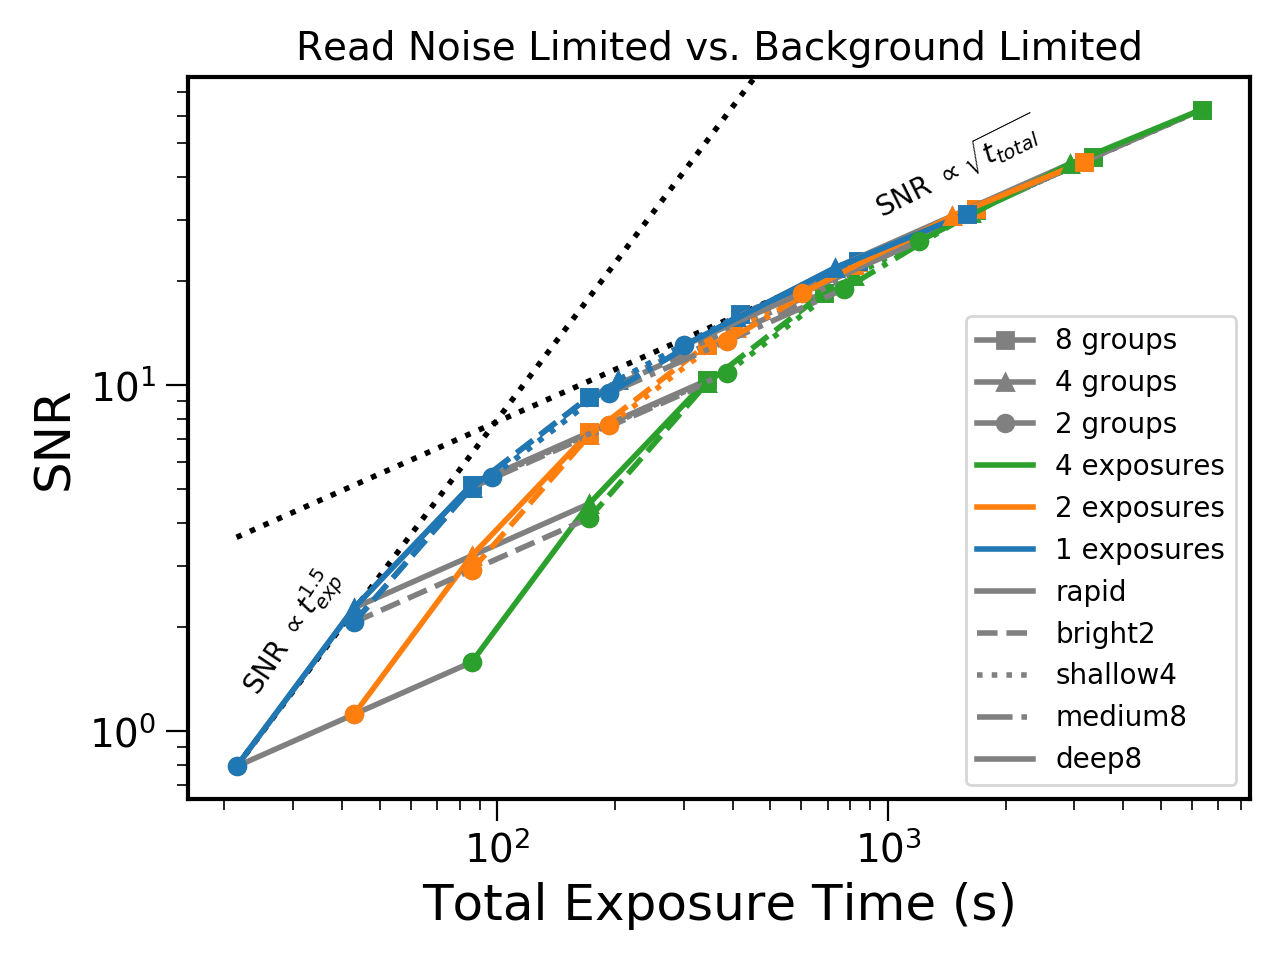

In [29]:
linestyles = '- -- : -. -'.split()
symbols = 'o^s'

fig = plt.figure()

for iread, readout_pattern in enumerate(readout_patterns):

    linestyle = linestyles[iread]
    
    for igroup in range(len(nngroup)-1, -1, -1):
        ngroup = nngroup[igroup]
        label='%d groups' % ngroup
        if iread: label = None
        plt.plot(exptimes[:,igroup,iread], SNRs[:,igroup,iread], symbols[igroup]+linestyle, color='0.50', label=label)
            
    for iexp in range(len(nnexp)-1, -1, -1):
        nexp = nnexp[iexp]
        color = colors[iexp]
        label='%d exposures' % nexp
        if iread: label = None        
        plt.plot(exptimes[iexp,:,iread], SNRs[iexp,:,iread], linestyle, color=color, label=label)

    for iexp in range(len(nnexp)-1, -1, -1):
        color = colors[iexp]
        for igroup in range(len(nngroup)-1, -1, -1):
            sym = symbols[igroup]
            plt.plot(exptimes[iexp,igroup,iread], SNRs[iexp,igroup,iread], sym, color=color)

    plt.plot(exptimes[iexp,:,iread], SNRs[iexp,:,iread], ls=linestyle, color='0.50', label=readout_pattern, zorder=-10)
    
plt.xlabel('Total Exposure Time (s)')
plt.ylabel('SNR')
plt.legend()
plt.loglog()

xlim = plt.xlim()
ylim = plt.ylim()

def log_interp(x, xp, yp):
    return 10 ** (np.interp(np.log10(x), np.log10(xp), np.log10(yp)))

# https://scipython.com/blog/rotating-text-onto-a-line-in-matplotlib/
color = 'k'

# Read Noise Limited: SNR ~ t ** 1.5
xtimes = np.geomspace(exptimes[0,0,0], exptimes[-1,-1,-1])
ySNR = SNRs[0,0,0] * (xtimes / exptimes[0,0,0]) ** 1.5
plt.plot(xtimes, ySNR, ':', color=color, zorder=-10)
label = 'SNR $\propto t_{exp}^{1.5}$'
dy = np.log10(ySNR[-1]) - np.log10(ySNR[0])
dx = np.log10(xtimes[-1]) - np.log10(xtimes[0])
xlabel = 30
ylabel = log_interp(xlabel, xtimes, ySNR)
xylabel = xlabel, ylabel
rotn = np.degrees(np.arctan2(dy, dx))
plt.annotate(label, xy=xylabel, rotation=rotn, ha='center')

# Background Limited: SNR ~ t ** 0.5
ySNR = SNRs[-1,-1,-1] * np.sqrt(xtimes / exptimes[-1,-1,-1])
plt.plot(xtimes, ySNR, ':', color=color, zorder=-10)
label = 'SNR $\propto \sqrt{t_{total}}$'
dy = np.log10(ySNR[-1]) - np.log10(ySNR[0])
dx = np.log10(xtimes[-1]) - np.log10(xtimes[0])
xlabel = 1500
ylabel = log_interp(xlabel, xtimes, ySNR)
xylabel = xlabel, ylabel
rotn = np.degrees(np.arctan2(dy, dx))
plt.annotate(label, xy=xylabel, rotation=rotn, ha='center')

plt.xlim(xlim)
plt.ylim(ylim)

plt.title('Read Noise Limited vs. Background Limited', fontsize=14)
plt.savefig('read_noise_vs_background_limited.png', dpi=200)